<a href="https://colab.research.google.com/github/Isabellitankian/FIAP---2023/blob/main/AWS_Rekognition_Faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Uso do AWS Rekognition

## 1.1) Acesso da webcam pelo google colab

In [ ]:
!pip install boto3

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import matplotlib.pyplot as plt

def take_photo(filename='foto.jpg', quality=0.8):

  #Embute funções javascript para trabalhar com o HTML do google colab (dom)
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Tirar Foto';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Redimensiono a imagem para adequar ao elemento html video
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  global data, binary

  data = eval_js('takePhoto({})'.format(quality))

  #transforma a imagem em binario
  binary = b64decode(data.split(',')[1])
  # print("imagem em binario:" + str(binary))
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Salvo no próprio colab em {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

## 1.2) Detectando faces e características na foto tirada

**Substitua as chaves aws pelas suas credenciais**

In [ ]:
chave_aws_id = '<suas_credenciais>'
chave_aws_secret = '<sua_senha>' 

In [ ]:
import boto3
rekognition = boto3.client('rekognition',"us-east-1",aws_access_key_id=chave_aws_id,
                        aws_secret_access_key=chave_aws_secret)

In [ ]:
detect_faces_response = rekognition.detect_faces(
    Attributes=['ALL'],
    Image={'Bytes': binary}
)

In [ ]:
print(detect_faces_response)

{'FaceDetails': [{'BoundingBox': {'Width': 0.2650953233242035, 'Height': 0.5185374617576599, 'Left': 0.31864672899246216, 'Top': 0.15816324949264526}, 'AgeRange': {'Low': 36, 'High': 44}, 'Smile': {'Value': False, 'Confidence': 94.93902587890625}, 'Eyeglasses': {'Value': False, 'Confidence': 97.30962371826172}, 'Sunglasses': {'Value': False, 'Confidence': 99.9964599609375}, 'Gender': {'Value': 'Male', 'Confidence': 99.99771881103516}, 'Beard': {'Value': True, 'Confidence': 87.11775207519531}, 'Mustache': {'Value': False, 'Confidence': 97.24076080322266}, 'EyesOpen': {'Value': True, 'Confidence': 96.82159423828125}, 'MouthOpen': {'Value': False, 'Confidence': 93.69931030273438}, 'Emotions': [{'Type': 'CALM', 'Confidence': 92.61875915527344}, {'Type': 'SURPRISED', 'Confidence': 7.224722862243652}, {'Type': 'FEAR', 'Confidence': 6.05678129196167}, {'Type': 'SAD', 'Confidence': 3.1200830936431885}, {'Type': 'CONFUSED', 'Confidence': 1.0732718706130981}, {'Type': 'DISGUSTED', 'Confidence': 

In [ ]:
import io
from PIL import Image, ImageDraw, ExifTags, ImageColor, ImageFont

stream = io.BytesIO(binary)
image=Image.open(stream)

imgWidth, imgHeight = image.size
draw = ImageDraw.Draw(image)

total_pessoas = len(detect_faces_response['FaceDetails'])
contagem_pessoas = 0
box = []
left = []
top=[]
width=[]
height=[]

idade_minima = []
idade_maxima = []
genero = []
sorrindo = []
sorrindo_conf = []
barba = []
emocoes = []
emocoes_conf =[]

for face in detect_faces_response['FaceDetails']:
  
  print(f'Pessoa nº: {str(contagem_pessoas + 1)} \n')

  idade_minima.append(face['AgeRange']['Low'])
  idade_maxima.append(face['AgeRange']['High'])
  genero.append(face['Gender']['Value'])

  sorrindo.append(face['Smile']['Value'])
  sorrindo_conf.append(face['Smile']['Confidence'])
  barba.append(face['Beard']['Value'])
  emocoes.append(face['Emotions'][0]['Type'])
  emocoes_conf.append(face['Emotions'][0]['Confidence'])
  

  box.append(face['BoundingBox'])
  left.append(imgWidth * box[contagem_pessoas]['Left'])
  top.append(imgHeight * box[contagem_pessoas]['Top'])
  width.append(imgWidth * box[contagem_pessoas]['Width'])
  height.append(imgHeight * box[contagem_pessoas]['Height'])
  
  print(f'Gênero: {genero[contagem_pessoas]} \n')
  print(f'Sorrindo: {sorrindo[contagem_pessoas]} \n')
  print(f'Barba: {barba[contagem_pessoas]} \n')
  print(f'Faixa etária: {idade_minima[contagem_pessoas]} - {idade_maxima[contagem_pessoas]} \n')
  print(f'Emoções: {emocoes[contagem_pessoas]} Confiança: {emocoes_conf[contagem_pessoas]} \n')

  contagem_pessoas +=1

Pessoa nº: 1 

Gênero: Male 

Sorrindo: False 

Barba: True 

Faixa etária: 36 - 44 

Emoções: CALM Confiança: 92.61875915527344 



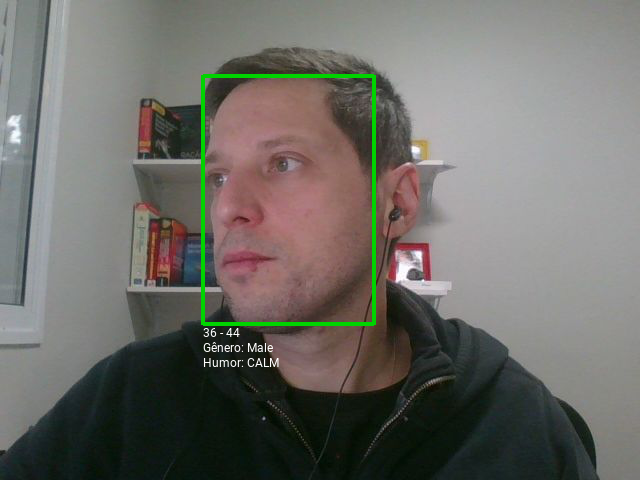

In [ ]:
import requests
import io
from io import BytesIO


contagem_pessoas = 0
req = requests.get("https://github.com/googlefonts/roboto/blob/main/src/hinted/Roboto-Regular.ttf?raw=true")
fnt = ImageFont.truetype(BytesIO(req.content), 12)

for face in detect_faces_response['FaceDetails']:

    points = (
              (left[contagem_pessoas],top[contagem_pessoas]),
              (left[contagem_pessoas] + width[contagem_pessoas], top[contagem_pessoas]),
              (left[contagem_pessoas] + width[contagem_pessoas], top[contagem_pessoas] + height[contagem_pessoas]),
              (left[contagem_pessoas] , top[contagem_pessoas] + height[contagem_pessoas]),
              (left[contagem_pessoas], top[contagem_pessoas])
              )

    # draw.text(xy=(imgWidth/2, 5), text=f'Faixa etária: {idade_minima} - {idade_maxima}', align='left')
    # draw.text(xy=(imgWidth/2, 15), text=f'Gênero: {genero}', align='left')
    # draw.text(xy=(imgWidth/2, 25), text=f'Estado emocional: {emocoes} - Confiança: {emocoes_conf}', align='left')
    # draw.text(xy=(imgWidth/2, 35), text=f'Sorrindo: {sorrindo} - Confiança: {sorrindo_conf}', align='left')
    # draw.text(xy=(imgWidth/2, 45), text=f'Total de Faces Detectadas: {total_pessoas}', align='left')

    if emocoes == 'ANGRY':
      draw.line(points, fill='red', width=4)
    else:
      draw.line(points, fill='#00d400', width=4)

      draw.text(xy=points[3], text=f'{idade_minima[contagem_pessoas]} - {idade_maxima[contagem_pessoas]}', align='left',font=fnt)
      draw.text(xy=(points[3][0], points[3][1]+15), text=f'Gênero: {genero[contagem_pessoas]}', align='left',font=fnt)
      draw.text(xy=(points[3][0], points[3][1]+30), text=f'Humor: {emocoes[contagem_pessoas]}', align='left',font=fnt)

    contagem_pessoas += 1

#draw.rectangle([left,top, left + width, top + height], outline='#00d400')
display(image)

In [ ]:
display(detect_faces_response)

{'FaceDetails': [{'AgeRange': {'High': 44, 'Low': 36},
   'Beard': {'Confidence': 87.11775207519531, 'Value': True},
   'BoundingBox': {'Height': 0.5185374617576599,
    'Left': 0.31864672899246216,
    'Top': 0.15816324949264526,
    'Width': 0.2650953233242035},
   'Confidence': 99.99797058105469,
   'Emotions': [{'Confidence': 92.61875915527344, 'Type': 'CALM'},
    {'Confidence': 7.224722862243652, 'Type': 'SURPRISED'},
    {'Confidence': 6.05678129196167, 'Type': 'FEAR'},
    {'Confidence': 3.1200830936431885, 'Type': 'SAD'},
    {'Confidence': 1.0732718706130981, 'Type': 'CONFUSED'},
    {'Confidence': 0.7188097834587097, 'Type': 'DISGUSTED'},
    {'Confidence': 0.4132732152938843, 'Type': 'ANGRY'},
    {'Confidence': 0.20535527169704437, 'Type': 'HAPPY'}],
   'Eyeglasses': {'Confidence': 97.30962371826172, 'Value': False},
   'EyesOpen': {'Confidence': 96.82159423828125, 'Value': True},
   'Gender': {'Confidence': 99.99771881103516, 'Value': 'Male'},
   'Landmarks': [{'Type': 'e

## 1.3) Detectando faces em uma foto do S3



In [ ]:
bucket_name = 'ftf-bucket-imagens'
image_name = 'imagem.jpeg'

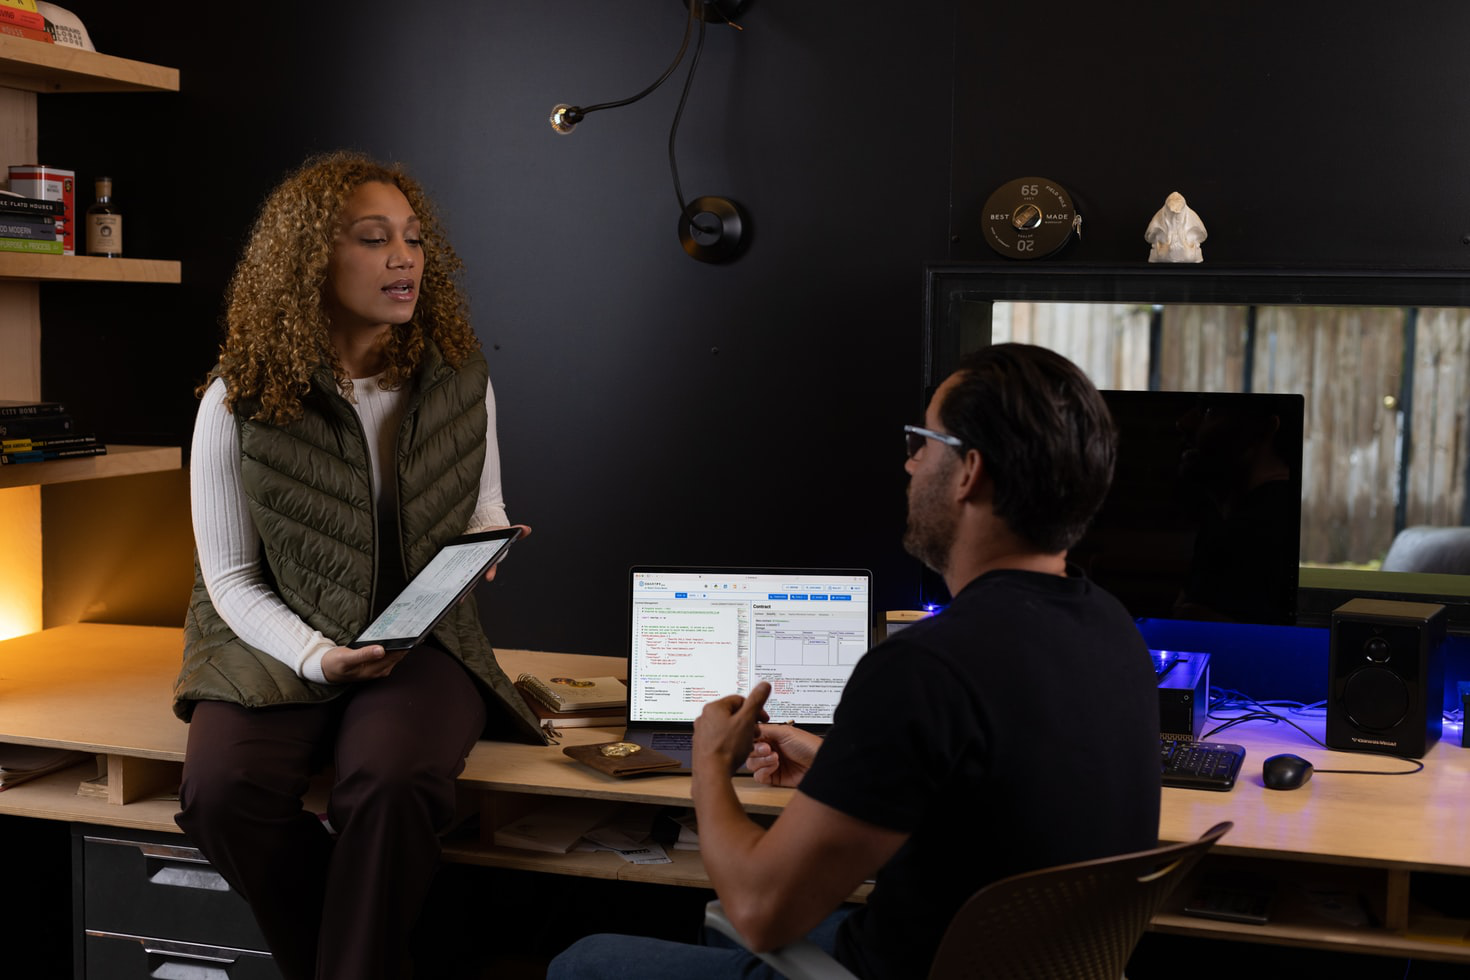

In [ ]:
import io
from io import BytesIO
from PIL import Image, ImageDraw, ExifTags, ImageColor, ImageFont

s3_connection = boto3.resource('s3',"us-east-1",aws_access_key_id=chave_aws_id,
                        aws_secret_access_key=chave_aws_secret)

s3_object = s3_connection.Object(bucket_name,image_name)
s3_response = s3_object.get()

stream = io.BytesIO(s3_response['Body'].read())
global imagem_s3
imagem_s3 = Image.open(stream)
imagem_s3

In [ ]:
detect_faces_response_s3 = rekognition.detect_faces(
    Attributes=['ALL'],
    Image={
        'S3Object': {
            'Bucket': bucket_name,
            'Name': image_name,
        }
    }
)

In [ ]:
# detect_faces_response_s3

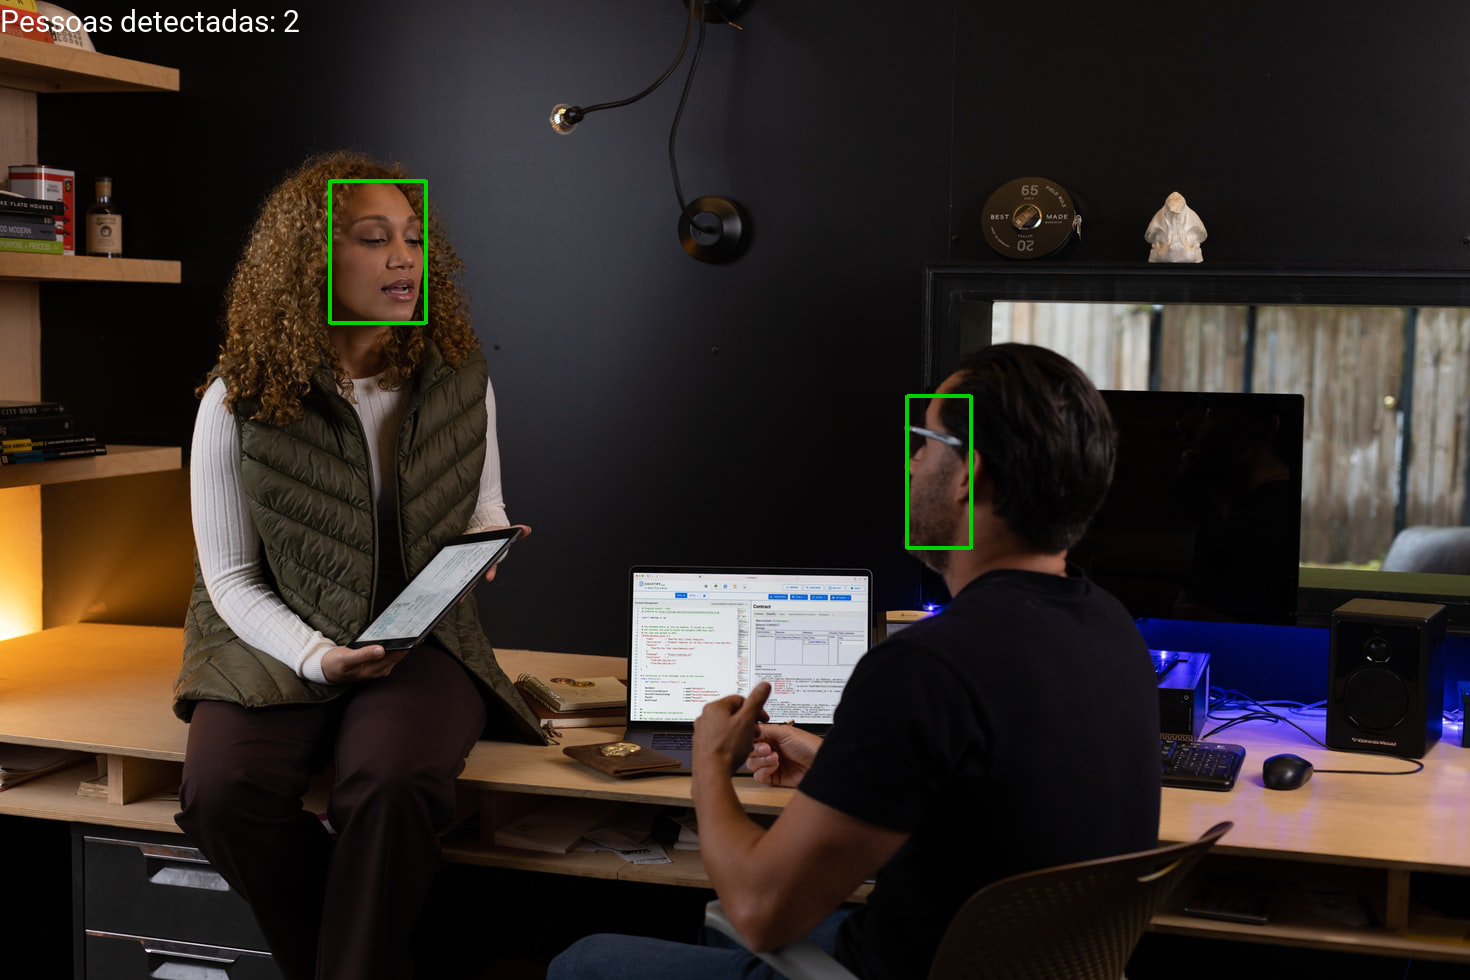

In [ ]:
import requests
import io
import PIL
from io import BytesIO
from PIL import Image, ImageDraw, ExifTags, ImageColor, ImageFont

req = requests.get("https://github.com/googlefonts/roboto/blob/main/src/hinted/Roboto-Regular.ttf?raw=true")
fnt = ImageFont.truetype(BytesIO(req.content), 30)

contagem_pessoas = 0

draw = ImageDraw.Draw(imagem_s3)

imgWidth, imgHeight = imagem_s3.size

draw.text(xy=(0.5,0.5), text=f"Pessoas detectadas: {len(detect_faces_response_s3['FaceDetails'])}", align='left',font=fnt)

for face in detect_faces_response_s3['FaceDetails']:

    height = imgHeight * face['BoundingBox']["Height"]
   
    left = imgWidth * face['BoundingBox']["Left"]

    top = imgHeight * face['BoundingBox']["Top"]

    width = imgWidth * face['BoundingBox']["Width"]
            
    points = (
              (left,top),
              (left + width, top),
              (left + width, top + height),
              (left , top + height),
              (left, top)
              )
    
    draw.line(points, fill='#00d400', width=4)

    contagem_pessoas += 1

imagem_s3